# Message Passing and Graph Attentional Networks
## Outline
1. Recap: Machine Learning with Graphs
1. Theory: Message Passing
1. Theory: Attention Mechanisms
    1. Classic (Sequence-Based) Attention
    1. Graph (Neighborhood-Based) Attention
1. Code: DGL Introduction
1. Code: Graph Attention Networks for Node Classification
    1. Model Overview
    1. Graph Attention Layer
    1. Multiheaded GAT Layer
    1. Combined Model
    1. Training and Evaluation
        1. Transductive Learning (Cora dataset)
        1. Inductive Learning (PPI dataset)

# Recap: Machine Learning with Graphs
Last time, we discussed two kinds of graphs: a simple graph containing only nodes and relations, and one 
containing _typed_ nodes and _typed_ relations (e.g. a knowledge graph).

<table>
    <tr style="background:transparent">
        <td style="width:400px;align:left"><img src="img/ex_graph_simple.png" width="300" align="left"></td>
        <td style="width:400px;align:right"><img src="img/ex_graph_complex.png" width="300" align="right"></td>
    </tr>
    <tr style="background:transparent">
        <td style="width:400px;text-align:center">Simple Graph</td>
        <td style="width:400px;text-align:center">Graph with typed nodes / relations</td>
    </tr>
</table>

Graphs are useful data structures for many tasks, but it can be difficult to apply machine learning approaches to graphs.
* Graphs can contain an arbitrary number of entities
* Entities may relate to one another in an arbitrary number of ways (some have few links, some have many)
* The underlying structure of the graph (usually) contains important information, but may be difficult to encode

The first step in handling these challenges is to learn a representation for the entities (nodes) in the graph that 
somehow takes the structure of the graph into account. Specifically, it is often the case that we want to take some 
vector representation for a node, $h \in \mathbb{R}^F$ (where $F$ is the length of the input vector), and transform 
it into some vector representation $h^\prime \in \mathbb{R}^{F^\prime}$ (where $F^\prime$ is the length of the 
output vector), such that $h^\prime$ describes a node _with respect to the graph structure_. 

<img src="img/diag_node_rep_lrn.png?arg" width="750" align="center">

After these embeddings are learned, other ML techniques (i.e. those not designed for graphs) can be used for tasks like node classification and relation prediction. 


## Node Representation Learning
Last time, we talked about Graph Convolutional Networks (GCNs). A GCN passes filters over the graph to learn its structure. The GCN can be said to learn graph region representations as the filters move across the graph. 

We can instead look at learning node representations iteratively, letting nodes inform their neighbors during each iteration. The neighbors will then inform _their_ neighbors, and so on. This mechanism is called message passing. 

# Theory: Message Passing
In the general node representation scheme, we want to take node representations, $h$, and transform them into 
structurally-aware node representations, $h^\prime$.

Message passing is an iterative approach that combines the representations of a node, $h_{t-1}$, with the representations of the node's neighbors to produce a new node representation $h_t$. At its most basic, the idea is as follows:
1. Collect neighboring (adjacent) nodes
1. For each neighbor, prepare a "message": some function, $f$, which combines the neighbor, the node, and the edge 
between them.
1. Combine the messages together with the previous time step's node representation ($h_{t-1}$) to produce the 
current time step's node representation ($h_t$)
1. Repeat as necessary

A visual example of this process is shown below:

<table>
    <tr style="background:transparent">
        <td colspan=3 style="width:600px;align:left"><img src="img/diag_msg_passing_node.png?arg" width="600"></td>
    </tr>
    <tr style="background:transparent">
        <td style="width:250px;text-align:center">Collect Blue Neighbors</td>
        <td style="width:250px;text-align:center">Prepare Messages</td>
        <td style="width:250px;text-align:center">Reduce (Combine) Messages with Blue Node</td>
    </tr>
</table>

The above describes what happens with a single node, but the process actually takes place across the entire graph. 
At each time step, each node receives messages from its neighbors simultaneously, and each updates itself simultaneously. In this way, each node $h^i_t$ always receives messages from node $h^j_t$, rather than any other arbitrary time step.

From this perspective, the message passing process can be thought of a time-series problem, where the graph is updated in its entirety each time step.

<img src="img/diag_msg_passing_graph.png?arg" width="800">

It may be helpful to think of this messsage passing mechanism as an increased perceptive field. At the first time step, a node knows only about its direct neighbors. At the second, it knows a little bit about what its neighbors know about _their_ neighbors, and so on. Visually, we can see this in the way the yellow node in the diagram has some blue in the first time step and some red in the second: the information about the nodes are propagating through the passed 
messages. 

Now that we have these structurally-aware node representations, we can use them for our chosen task, like node classification.

# Theory: Attention Mechanisms
Attention is an approach that gained popularity as a mechanism for learning alignments between different modalities (e.g. images and captions, speech and text, etc.). At a high level, attention learns to weigh (pay attention to) elements differently, depending on the task and the input. The most common framing of attention is with sequences, but this scheme can be applied with many structures (including graphs).

## Classic (Sequence-Based) Attention
Consider a task (like part-of-speech tagging) where we want to learn something about items in a sequence (words in a sentence) while being aware of the context (the other words in the sentence). Typically, we would encode this contextual information with an RNN, where each word is informed by the previous words.

This process, however, often loses long-term information. Attention addresses this by allowing the model to learn over the entire sequence (or some large subsequence), weighing the other items by how important they are to the item of interest. Attention mechanisms do this by applying a weight vector over the other sequence elements (all the weights add up to 1) before combining their representations into a single context vector.

<table style="align=center;width:100%">
    <tr style="background:transparent">
        <td><img src="img/diag_luong_attn.png?arg" width="300"></td>
    </tr>
    <tr style="background:transparent">
        <td style="text-align:center">Image from <a href="https://arxiv.org/pdf/1508.04025">Luong et al. 2015</a></td>
    </tr>
</table>

## Graph (Neighborhood-Based) Attention
Attention is based on the premise that each input sample does not exist in isolatation; preceding words in a sentence can influence the meaning of later words. At it's simplest, then, attention is a way for a model to learn "by how much should each item be influenced by its neighbors?" 

When using attention with graphs, this intuition is applied literally: a node's context-aware representation combines its representation with the attention-weighted sum of its neighbors (adjacent graph nodes). As with sequences, an attention mechanism learns a weight vector that is then applied to the neighbors.

<table style="align=center;width:100%">
    <tr style="background:transparent">
        <td><img src="img/diag_graph_attn.png?arg" width="300"></td>
    </tr>
    <tr style="background:transparent">
        <td style="text-align:center">Image from <a href="https://arxiv.org/pdf/1710.10903.pdf">Veličković et al. 2017</a></td>
    </tr>
</table>

In the example diagram, each of the colors represents a separate attention mechanism; each produces a separate representation -- $h^k_1$ -- that are then combined via concatenation or averaging to produce a final node representation: $h^{\prime}_1$. 

### Attention as a Message Function
In the message passing scheme, we can treat the attention mechanism as the part of the function $f$ with which we prepare messages. We weigh the neighbor's influence by it's attention-defined importance, that neighbor is packaged as a message, which is combined with the other neighbor's messages, and so on.

# Code: Deep Graph Library Introduction
The [Deep Graph Library](https://docs.dgl.ai/) (DGL) is a Python library built especially for graph neural networks (GNNs) which wraps and extends the functionality of other libraries like PyTorch (for deep learning) and MXNet (for graph representations). While DGL is by no means necessary for implementing GNNs, it makes the process significantly faster and easier (once the basics are understood).

#### DGLGraph
DGL represents graphs with DGLGraph objects, which are not only used to store the graph as an input to the system, but are the main structure by which the network stores variables (nodes and edges take dictionaries of variable names and values).

#### apply\_edges(fn)
The built-in DGLGraph function *apply\_edges* applies function *fn* to the graph edges, which typically allows us to compute some intermediate representation for each edge in the graph.
* *fn* must be implemented; it must accept a list of edges and return a dictionary of {var\_name: value} which will be stored in the graph edges.

#### update\_all(message\_fn, reduce\_fn)
The built-in DGLGraph function *update\_all* runs the *message\_fn* function over edges (to prepare messages) and combines those messages with the *reduce\_fn* function to update the node representations in the graph. 
* *message\_fn* must be implemented; it accepts a list of edges and returns a dictionary of {var\_name: value} which DGL stores in each node's mailbox
* *reduce\_fn* must be implemented; it accepts a list of nodes, operates over their mailbox, and returns a dictionary of {var\_name: value} which updates node representations
    
While DGL is complex and has many features, these basics will allow us to move forward with implementing a simple GNN.

# Code: Graph Attention Networks for Node Classification
## Model Overview
Graph Attention Networks (GATs) -- specifically as defined by [Veličković et al. 2017](https://arxiv.org/pdf/1710.10903.pdf) -- are a type of neural architecture designed to learn node representations for graphs of arbitrary size and structure. This is accomplished using attention over node neighbors (adjacent graph nodes). 

With a GAT, our goal is to learn context-aware node representations: specifically transforming vector $\mathbf{h}_i \in \mathbb{R}^F$ to representation $\mathbf{h}^\prime_i \in \mathbb{R}^{F^\prime}$, where $F$ is not necessarily the same as $F^\prime$.

To learn this representation, we must compute edges $e_{ij}$ for the neighborhood around each node $n_i$ ($j \in \mathcal{N}_i$).


<table style="align=center;width:100%">
    <tr style="background:transparent">
        <td><img src="img/ex_graph_neighbor_1.png?arg" width="300"></td>
    </tr>
    <tr style="background:transparent">
        <td style="text-align:center">Node $n_i$ shown in white; neighborhood $\mathcal{N}_i$ shown in aqua</td>
    </tr>
</table>

To compute these edges, node representations are linearlly projected into an output vector space with a weight matrix: $\mathbf{W} \in \mathbb{R}^{F \times F^\prime}$. These projections are concatenated to form a single $2F^\prime$-length vector.

$$e_{ij} = [\mathbf{W}\mathbf{h}_i, \mathbf{W}\mathbf{h}_j]$$

Given these edge representations, we apply attention mechanism, $\alpha$, to determine how important node $n_j$ is _with respect to_ node $n_i$.
 
$$a_{ij} = \alpha(e_{ij})$$

While there are many available choices for $\alpha$, the simplest is a feed-forward network which multiples the concatenated node projections by weight vector $\mathbf{a}$, passes the resulting scalar through a nonlinearity, and applies the softmax function over the edge representations.

$$a_{ij} = \mathit{softmax}_j \left(\mathit{LeakyReLU}\left(\mathbf{a}^\top e_{ij}\right) \right) = \dfrac{\mathit{exp}\left(\mathit{LeakyReLU}\left(\mathbf{a}^\top [\mathbf{W}\mathbf{h}_i, \mathbf{W}\mathbf{h}_j]\right) \right) }{\sum\limits_{l \in \mathcal{N}_i}\mathit{exp}\left(\mathit{LeakyReLU}\left(\mathbf{a}^\top [\mathbf{W}\mathbf{h}_i, \mathbf{W}\mathbf{h}_l]\right)\right)} $$

The final output representation is the attention-weighted sum of the neighborhood vectors (where $i$ is added to $\mathcal{N}_i$ in order to provide the node access to its own vector).

$$\mathbf{h}^\prime_i = \sum\limits_{j \in \mathcal{N}_i} a_{ij} \mathbf{W}\mathbf{h}_j$$

In order to stabalize learning, the original authors employ multiheaded attention, concatenating $K$ separate attention mechanisms (heads) to produce a final represention.

$$\mathbf{h}^\prime_i = \bigg\Vert^K_k\sum\limits_{j \in \mathcal{N}_i} a^k_{ij} \mathbf{W}^k\mathbf{h}_j$$

## Graph Attention Layer
The core of the GAT model is the GATlayer, which computes node representation $h^k_i$ (the output node representations using attention mechanism $k$). Below, the GATLayer class (which inherits from torch.nn.Module) contains the following functions:
* \_\_init\_\_
    * stores the given graph internally
    * creates and initializes the node transformation matrix, $\mathbf{W}$
    * creates and initializes the edge transformation vector, $\mathbf{a}$
* \_calc\_edge\_attn\_fn
    * concatenates projected node vectors ($z_i = \mathbf{W}^k \mathbf{h}_i$)
    * multiplies concatenated vector by the edge transformation vector, and passes the resulting scalar through a nonlinearity: $\mathit{LeakyReLU}(\mathbf{a}^{k\top} [z_i, z_j])$
* \_message\_fn
    * packages the internal $z$ and $e$ variables into the DGLGraph's node mailboxes
* \_reduce\_fn
    * computes the attention weights by applying softmax over the edge values computed by \_calc\_edge\_attn\_fn
    * multiples attention weights to projected node representations and sums these together to produce a new node representation $\mathbf{h}^k_i = \sum\limits_{j \in \mathcal{N}_i} a^k_{ij} \mathbf{W}^k\mathbf{h}_j$
* forward
    * overridden from torch.nn.Module
    * linearlly transforms input node representations to the output space ($z_i = \mathbf{W}^k \mathbf{h}_i$)
    * calls apply\_edges (using \_calc\_edge\_attn\_fn) to update edge values
    * calls update\_all to update node representations via message passing

In [1]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_func
import torch.nn.init as torch_init

from dgl import DGLGraph

class GATLayer(torch_nn.Module):
    """
    Graph Attention Network layer; computes attention values over
    each node's neighborhood (adjacent nodes) and returns a node
    representation combining the node's original embedding with
    the attention-weighted neighbors
    """

    def __init__(self, graph, input_embed_len, output_embed_len, attn_dropout_proba=0.0):
        """
        Initializes the GATLayer for the given graph

        :param graph: graph on which this layer will be applied
        :param input_embed_len: the length of the input node embeddings
        :param output_embed_len: length of the node embeddings this layer
            will output
        :param attn_dropout_proba: probability that a normalized attention
            weight will be dropped
        """
        super(GATLayer, self).__init__()

        self._graph = graph

        # create a simple linear projection from the input node
        # embeddings to the output embeddings
        self._node_lin_transf = torch_nn.Linear(input_embed_len, output_embed_len, bias=False)

        # create the internal attention parameters (transforming the
        # concatenated node features to a raw scalar)
        self._attn_lin_transf = torch_nn.Linear(2 * output_embed_len, 1, bias=False)

        # create a dropout sub-module to apply to the attention weights
        self._attn_dropout = torch_nn.Dropout(attn_dropout_proba)

        # initialize our parameters
        torch_init.xavier_normal_(self._node_lin_transf.weight)
        torch_init.xavier_normal_(self._attn_lin_transf.weight)
    #enddef

    def _calc_edge_attn_fn(self, edges):
        """
        Function which calculates (raw) edge attention values
        :param edges: graph edges
        :return: dictionary of {'e': <edge_attn_vals>}
        """
        # concatenate the transformed node embeddings
        z_cat = torch.cat([edges.src['z'], edges.dst['z']], dim=1)

        # return the raw attention scalar, passed through a nonlinearity
        return {'e': torch_func.leaky_relu(self._attn_lin_transf(z_cat))}
    #enddef

    def _message_fn(self, edges):
        """
        Function for message collection (as part of the message passing mechanism)

        :param edges: graph edges
        :return: dictionary of {'z': <projected_node_embeds>, 'e': <edge_attn_vals>}
        """
        # message function to collect projected node embeddings and
        # raw attention values
        return {'z': edges.src['z'], 'e': edges.data['e']}
    #enddef

    def _reduce_fn(self, nodes):
        """
        Function for message reduction (as part of the message passing mechanism)

        :param nodes: graph nodes
        :return: dictionary of {'h': <output_embeddings>}
        """
        # calculate attention weights as the softmax of the raw values across
        # neighborhoods;        [n_nodes]
        attn_weights = self._attn_dropout(torch_func.softmax(nodes.mailbox['e'], dim=1))

        # return the new node representation: an attention weighted sum
        # of each node's neighborhood (including itself)
        return {'h': torch.sum(attn_weights * nodes.mailbox['z'], dim=1)}
    #enddef

    def forward(self, h):
        """
        Torch module forward pass function; computes the layer's output node
        embeddings, given the layer's input node embeddings

        :param h: input node embeddings
        :return: output node embeddings
        """
        # project the node into the output space, applying dropout as we do so
        self._graph.ndata['z'] = self._node_lin_transf(h)

        # use the built-in apply_edges functionality to
        # calculate edge attention values for all edges
        self._graph.apply_edges(self._calc_edge_attn_fn)

        # update the nodes according to the message and reduce
        # functions, for this pass
        self._graph.update_all(self._message_fn, self._reduce_fn)
        return self._graph.ndata.pop('h')
    #enddef
    
    def swap_graph(self, graph):
        """
        Helper function to switch out the layer's internal graph
        :param graph: Replacement for the current internal graph
        """
        self._graph = graph
    #enddef
#endclass

Using backend: pytorch


## Multi-Headed GAT Layer
The MultiHeadGATLayer is another torch.nn.Module that combines multiple GATLayer objects. In short, it creates the $K$ attention heads and combines their outputs with a specified merge mode (either concatenation or averaging) during each forward pass.

In the equations above, this is the concatenation step: $\mathbf{h}^\prime_i = \bigg\Vert^K_k\sum\limits_{j \in \mathcal{N}_i} a^k_{ij} \mathbf{W}^k\mathbf{h}_j$

In [2]:
class MultiHeadGATLayer(torch_nn.Module):
    """
    Multi-headed Graph Attention Network layer, which combines
    multiple GATLayers
    """

    def __init__(self, graph, input_embed_len, output_embed_len, n_heads,
                 attn_dropout_proba=0.0, merge_mode='cat'):
        """
        Initializes the multi-headed graph attention layer, for the given graph

        :param graph: graph on which this layer will be applied
        :param input_embed_len: the length of the input node embeddings
        :param output_embed_len: length of the node embeddings this layer
            will output
        :param n_heads: number of heads (parallel GATLayers) to use
        :param attn_dropout_proba: probability that a normalized attention
            weight will be dropped
        :param merge_mode: how the multiple attention heads will be combined;
            one of ['cat', 'avg']
        """
        super(MultiHeadGATLayer, self).__init__()

        # create as many GATLayers as were specified
        self._attn_heads = torch_nn.ModuleList()
        for _ in range(n_heads):
            self._attn_heads.append(GATLayer(graph, input_embed_len, output_embed_len, attn_dropout_proba))

        # store our merge mode
        self._merge_mode = merge_mode
    #enddef

    def forward(self, h):
        """
        Torch module forward pass function; combines the GATLayers' output node
        embeddings, given the inputs

        :param h: input node embeddings
        :return: output node embeddings
        """
        # collect the outputs
        head_outputs = [attn_head(h) for attn_head in self._attn_heads]

        # merge them based on our merge mode (default is avg)
        if self._merge_mode == 'cat':
            return torch.cat(head_outputs, dim=1)
        return torch.mean(torch.stack(head_outputs), dim=0)
    #enddef
    
    def swap_graph(self, graph):
        """
        Helper function to switch out the layer's internal graph
        :param graph: Replacement for the current internal graph
        """
        for gat_layer in self._attn_heads:
            gat_layer.swap_graph(graph)
    #enddef
#endclass

## Combined Model
We can now apply the GAT-learned node representations to the task of node classification. In the GAT module, we retrieve the learned node representations from a MultiHeadGATLayer, pass them through a nonlinearity (the ELU function), and apply a single layer to these representations to transform the node vectors to our label space. For ease of implementation, we use another GAT layer, but any network layer can be used here.


<table style="align:center;width:100%">
    <tr style="background:transparent">
        <td><img src="img/diag_gat_model.png?arg" width="400"></td>
    </tr>
    <tr style="background:transparent">
        <td style="text-align:center;width:400">GAT attention learns new node embedding for $h_0$; new node embeddings <br/> are combined; layer is applied to predict score for each possible label</td>
    </tr>
</table>

In [3]:
class GAT(torch_nn.Module):
    """
    Graph Attention Network model, which applies the multi-headed GAT layer
    (over inputs) with a single GAT layer (over intermediate embeddings) to predict
    node classes
    """

    def __init__(self, graph, input_embed_len, hidden_embed_len, n_labels, n_heads,
                 input_dropout_proba=0.0, attn_dropout_proba=0.0, intermed_dropout_proba=0.0):
        """
        Initializes the GAT model, given the graph

        :param graph: graph on which this layer will be applied
        :param input_embed_len: the length of the input node embeddings
        :param hidden_embed_len: length of the node embeddings the multi-headed
            GAT layer will output
        :param n_labels: number of labels
        :param n_heads: number of heads (parallel GATLayers) to use
        :param input_dropout_proba: probability that an input feature will be dropped
        :param attn_dropout_proba: probability that a normalized attention
            weight will be dropped
        :param intermed_dropout_proba: probability that one of the features of the
            intermediate node embeddings will be dropped
        """
        super(GAT, self).__init__()

        # the first layer uses the multi-headed GAT approach to transform node embeddings
        # from input_embed_len to hidden_embed_len (attending over neighborhoods as it does so)
        self._multi_headed_gat_layer = MultiHeadGATLayer(
            graph, input_embed_len, hidden_embed_len, n_heads, attn_dropout_proba)

        # the second layer transforms those new embeddings into the label space, which
        # can be done with any kind of layer, but for simplicity we'll reuse our attention setup
        self._label_proj_layer = GATLayer(graph, hidden_embed_len * n_heads, n_labels)

        # define two dropout sub-modules for the inputs and intermediate embeddings, respectively
        self._input_dropout = torch_nn.Dropout(input_dropout_proba)
        self._intermed_dropout = torch_nn.Dropout(intermed_dropout_proba)
    #enddef

    def forward(self, h):
        """
        Torch module forward pass function; passing the inputs through the multi-headed
        GAT layer, a nonlinearity, and projects those intermediate representations into
        the label space

        :param h: input node embeddings
        :return: label distribution (raw logits)
        """
        # in each step, we want to
        #   1) apply dropout over inputs
        #   2) attend over input embeddings' neighborhoods
        #   3) pass those embeddings through a nonlinearity
        #   4) apply dropout to those intermediate embeddings
        #   5) project those new embeddings into the label space
        intermed = torch_func.elu(self._multi_headed_gat_layer(self._input_dropout(h)))
        return self._label_proj_layer(self._intermed_dropout(intermed))
    #enddef
#endclass

## Transductive Learning
In the transductive learning setting, the model is aware of the entire graph (that is, it knows which nodes are connected to which others and is given all nodes' input embeddings) but only sees the labels (and computes loss) for training nodes. In this sense, the model knows that testing nodes exist -- and updates their representations -- but is never made aware of what those nodes _are_.

### Data
To train our model, we'll be using the Cora citation dataset, where each node represents a paper, each edge represents a citation (X cited Y), and each node takes one of seven labels (paper category. 

<table style="align=center;width:100%">
    <tr style="background:transparent">
        <td><img src="img/ex_cora.png?arg" width="500"></td>
    </tr>
    <tr style="background:transparent">
        <td style="text-align:center">Random selection of 1,000 nodes from the Cora dataset; each class (paper category) is shown in a different color</td>
    </tr>
</table>

The Cora datset is built in to DGL, so we can download it directly from there.

In [4]:
from collections import namedtuple

def load_cora():
    """
    Loads one of the DGL-hosted Cora dataset

    :return: namedtuple for the citation graph dataset; attributes:
        [graph, features, labels, mask]
    """
    from dgl.data import citation_graph
    dataset = citation_graph.load_cora()
    
    # return the datasets' components
    dataset_tuple = namedtuple("citation_graph", ["graph", "features", "labels", "mask"])
    return dataset_tuple(DGLGraph(dataset.graph), torch.FloatTensor(dataset.features),
                         torch.LongTensor(dataset.labels), torch.BoolTensor(dataset.train_mask))
#enddef

### Hyperparameters
Typically, we would spend some time experimenting with a held-out portion of the final training data (development or validation set) to determine the best values for the various tunable knobs in the network. Since we're following [Veličković et al. 2017](https://arxiv.org/pdf/1710.10903.pdf), we can simply use the ones they list in their paper. 

<table style="align:center;width:90%">
    <tr>
        <th style="width:22%">Name</th>
        <th style="width:8%">Values</th>
        <th style="width:60%">Comments</th>
    </tr>
    <tr>
        <td>epochs</td>
        <td>100</td>
        <td></td>
    </tr>
    <tr>
        <td>batch size</td>
        <td>1</td>
        <td>They don't specify this, but it's sensible given the rest of the setup</td>
    </tr>
    <tr>
        <td>number of attention heads ($K$)</td>
        <td>8</td>
        <td></td>
    </tr>
    <tr>
        <td>output embedding length ($F^\prime$)</td>
        <td>8</td>
        <td></td>
    </tr>
    <tr>
        <td>input dropout rate</td>
        <td>0.6</td>
        <td>Applying dropout to inputs is a common regularization method</td>
    </tr>
    <tr>
        <td>attention dropout rate</td>
        <td>0.6</td>
        <td>This has the effect of randomly subsampling the neighborhoods during attention weight computation on each batch</td>
    </tr>
    <tr>
        <td>projection dropout rate</td>
        <td>0.6</td>
        <td></td>
    </tr>
    <tr>
        <td>learning rate</td>
        <td>0.005</td>
        <td></td>
    </tr>
    <tr>
        <td>L2 Regularization $\lambda$</td>
        <td>0.0005</td>
        <td>This value is referred to as the training weight decay in PyTorch's optimizer</td>
    </tr>
</table>

<font color="#48DAD0">Note that dropout is included here and has in fact been used throughout the GAT implementation; understanding dropout is not a requirement for understanding GATs specifically or GNNs generally, though for completeness it is a mechanism to help the model generalize better. Of special note in the GAT implementation is that by applying it to the attention weight vector, each time step randomly subsamples their neighborhood, rather than always looking at all adjacent nodes.</font>

### Training
Combining all these components, we can define our PyTorch training function. After defining the hyperparameters and loading the data, we
1. Create the GAT model
1. Create a PyTorch optimizer
1. For each of the specified epochs (iterations over the training data)
    1. Predict labels for each node using the current model
    1. Compute loss by comparing the predicted training labels with the actual training labels
    1. Use the built-in PyTorch functionality to update model weights via backpropagation

In [5]:
hidden_embed_len = 8
n_heads = 8
n_epochs = 100
lrn_rate = 5e-3
train_weight_decay = 5e-4
input_dropout_proba, attn_dropout_proba, intermed_dropout_proba = 0.6, 0.6, 0.6

# load the dataset, collecting data-dependent variables
data_vars = load_cora()
n_nodes, input_embed_len = data_vars.features.size()[:2]
n_labels = int(max(data_vars.labels)) + 1

# create a new model
gat_model = GAT(data_vars.graph, input_embed_len=input_embed_len,
                hidden_embed_len=hidden_embed_len, n_labels=n_labels,
                n_heads=n_heads, input_dropout_proba=input_dropout_proba,
                attn_dropout_proba=attn_dropout_proba,
                intermed_dropout_proba=intermed_dropout_proba)

# create an optimizer for the model's parameters
optimizer = torch.optim.Adam(gat_model.parameters(), lr=lrn_rate,
                             weight_decay=train_weight_decay)

# train
for epoch_idx in range(n_epochs):
    # run our model, getting 1) raw logits 2) log probabilities, and
    # 3) calculating negative log likelihood loss over our training samples
    logits = gat_model(data_vars.features)
    log_prob = torch_func.log_softmax(logits, 1)
    loss = torch_func.nll_loss(log_prob[data_vars.mask], data_vars.labels[data_vars.mask])

    # optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch_idx + 1) % 10 == 0:
        print("Epoch: {:02d}; Loss: {:.03f}".format(epoch_idx+1, loss.item()))
#endfor

Epoch: 10; Loss: 1.850
Epoch: 20; Loss: 1.705
Epoch: 30; Loss: 1.553
Epoch: 40; Loss: 1.349
Epoch: 50; Loss: 1.119
Epoch: 60; Loss: 0.968
Epoch: 70; Loss: 0.883
Epoch: 80; Loss: 0.712
Epoch: 90; Loss: 0.661
Epoch: 100; Loss: 0.643


### Evaluation
As is typical for node classification models, we measure the accuracy of our predictions for the testing nodes. In the [Veličković et al. 2017](https://arxiv.org/pdf/1710.10903.pdf) paper, the GAT model acheived ~83% accuracy on the Cora dataset.

In [6]:
from numpy.random import shuffle as np_shuffle

# As in the paper, we're going to grab 1000 random nodes
eval_indices = [i for i in range(n_nodes) if not data_vars.mask[i]]
np_shuffle(eval_indices)
eval_indices = set(eval_indices[:1000])
eval_mask = [i in eval_indices for i in range(n_nodes)]

gat_model.eval()
with torch.no_grad():
    logits = gat_model(data_vars.features)[eval_mask]
    y = data_vars.labels[eval_mask]
    _, y_pred = torch.max(logits, dim=1)
    pred_labels = list(y_pred.numpy())
    print("Accuracy: {:.2f}%".format(100.0 * torch.sum(y_pred == y).item() * 1.0 / len(y)))
#endwith

Accuracy: 75.70%


While our results aren't exactly the same as those reported in the paper, they're reasonably close (especially given that the reported results were averaged after 100 runs). This suggests that our GAT model is working as expected in the transductive setting.

As a sanity check, we can also show the graphs side by side (gold and predicted).

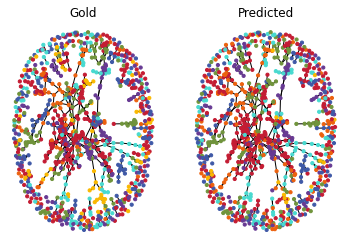

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# We're going to draw the evaluation graph twice; once with the gold
# label colorings and once with the predicted
eval_nodes = data_vars.graph.nodes()[eval_mask]
eval_graph = data_vars.graph.subgraph(eval_nodes).to_networkx().to_undirected()

herecolors = ['#48DAD0', '#673A93', '#C41C33', '#3F59A7',
              '#EC610E', '#FAB800', '#70943C']
figs, axes = plt.subplots(nrows=1, ncols=2)
positions = nx.spring_layout(eval_graph, k=0.0625)

gold_colors = [herecolors[l] for l in data_vars.labels[eval_mask]]
pred_colors = [herecolors[l] for l in pred_labels]
axes[0].set_title("Gold")
nx.draw(eval_graph, node_color=gold_colors, with_labels=False,
        node_size=10, ax=axes[0], pos=positions)
axes[1].set_title("Predicted")
nx.draw(eval_graph, node_color=pred_colors, with_labels=False,
        node_size=10, ax=axes[1], pos=positions)
plt.show()

## Inductive Learning
In the inductive setting, the models learns from training nodes / graphs and predicts on entirely unseen nodes. 

### Data
To train a GAT in the inductive setting, we'll be using the Protein-Protein Interaction (PPI) dataset, where graphs correspond to different human tissues. In this setting, the model will learn over training graphs and predict over test graphs. As with Cora, PPI is built in to DGL. Retrieving it is a little more complex, however, and we'll do so with DGL's data loaders.

In short, the *load\_ppi* function accepts a batch size (number of training graphs seen during each iteration) and returns a namedtuple of data attributes and the train and test data loaders. 

In [8]:
import numpy as np

def load_ppi(batch_size):
    """
    Loads the DGL-hosted PPI dataset

    :param batch_size: number of samples in each batch
    :return: namedtuple for the PPI graph dataset; attributes:
        [input_embed_len, n_labels, train_graph, train_loader, test_loader]
    """
    from dgl.data.ppi import LegacyPPIDataset
    from torch.utils.data import DataLoader
    from dgl import batch as dgl_batch

    def collate_fn(sample):
        """
        Helper function for the torch dataloader
        """
        graphs, feats, labels = map(list, zip(*sample))
        graph = dgl_batch(graphs)
        feats = torch.from_numpy(np.concatenate(feats))
        labels = torch.from_numpy(np.concatenate(labels))
        return graph, feats, labels
    #enddef

    # create and return the dataset
    train_data = LegacyPPIDataset(mode='train')
    train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(LegacyPPIDataset(mode='test'), batch_size=batch_size, 
                             collate_fn=collate_fn)
    data_tuple = namedtuple("data_vars", ["input_embed_len", "n_labels", "train_graph",
                                          "train_loader", "test_loader"])
    return data_tuple(train_data.features.shape[1], train_data.labels.shape[1],
                      train_data.graph, train_loader, test_loader)
#enddef

### ThreeLayerGAT
The inductive model proposed by [Veličković et al. 2017](https://arxiv.org/pdf/1710.10903.pdf) is a variation on the original model. In the ThreeLayerGAT module, multiheaded attention mechanisms are used three times, where the first two concatenate their heads' results, and the last averages.

In [9]:
class ThreeLayerGAT(torch_nn.Module):
    """
    Graph Attention Network model for a three-layer GAT as specified by the
    inductive learning setup in the original GAT paper; two multi-headed layers
    are used before passing the resulting embeddings to a final layer which predicts
    node classes
    """

    def __init__(self, graph, input_embed_len, hidden_embed_len, n_labels,
                 n_start_heads, n_end_heads):
        """
        Initializes the GAT model, given the graph

        :param graph: graph on which this layer will be applied
        :param input_embed_len: the length of the input node embeddings
        :param hidden_embed_len: length of the node embeddings the multi-headed
            GAT layer will output
        :param n_labels: number of labels
        :param n_start_heads: number of heads (parallel GATLayers) to use in the
            first two layers
        :param n_end_heads: number of heads (parallel GATLayers) to use in the
            final layer
        """
        super(ThreeLayerGAT, self).__init__()

        # the first layer uses the multi-headed GAT approach to transform node embeddings
        # from input_embed_len to hidden_embed_len (attending over neighborhoods as it does so)
        self._multi_headed_gat_layer_1 = MultiHeadGATLayer(
            graph, input_embed_len, hidden_embed_len, n_start_heads, merge_mode='cat')
        multiheaded_emebed_len = hidden_embed_len * n_start_heads

        # the second layer also uses the multi-headed GAT approach, but does not change the
        # length of the node representations
        self._multi_headed_gat_layer_2 = MultiHeadGATLayer(
            graph, multiheaded_emebed_len, hidden_embed_len, n_start_heads, merge_mode='cat')

        # the final layer transforms those new embeddings into the label space, again using
        # the multi-headed GAT approach
        self._multi_headed_gat_layer_3 = MultiHeadGATLayer(
            graph, multiheaded_emebed_len, n_labels, n_end_heads, merge_mode='avg')
    #enddef

    def forward(self, h):
        """
        Torch module forward pass function; passing the inputs through the multi-headed
        GAT layers to predict labels

        :param h: input node embeddings
        :return: label distribution (raw logits)
        """
        intermed_1 = torch_func.elu(self._multi_headed_gat_layer_1(h))
        intermed_2 = torch_func.elu(self._multi_headed_gat_layer_2(intermed_1))
        return self._multi_headed_gat_layer_3(intermed_2)
    #enddef

    def swap_graph(self, graph):
        """
        Helper function to switch out the layer's internal graph
        :param graph: Replacement for the current internal graph
        """
        self._multi_headed_gat_layer_1.swap_graph(graph)
        self._multi_headed_gat_layer_2.swap_graph(graph)
        self._multi_headed_gat_layer_3.swap_graph(graph)
    #enddef
#endclass

### Hyperparameters
In the inductive learning case, we don't apply dropout nor do we use L2 regularization to training.

<table style="align:center;width:90%">
    <tr>
        <th style="width:40%">Name</th>
        <th style="width:8%">Values</th>
        <th style="width:42%">Comments</th>
    </tr>
    <tr>
        <td>epochs</td>
        <td><strike>100</strike> 10</td>
        <td>While the original paper uses 100 epochs, this was impractical for this example</td>
    </tr>
    <tr>
        <td>batch size</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>number of $1^{\textit{st}}$ and $2^{\textit{nd}}$ layer attention heads ($K_0$, $K_1$)</td>
        <td>4</td>
        <td></td>
    </tr>
    <tr>
        <td>$1^{\textit{st}}$ and $2^{\textit{nd}}$ layer output embedding length ($F^\prime_0$, $F^\prime_1$)</td>
        <td>256</td>
        <td></td>
    </tr>
    <tr>
        <td>number of $3^{\textit{rd}}$ layer attention heads ($K_2$)</td>
        <td>6</td>
        <td></td>
    </tr>
    <tr>
        <td>$3^{\textit{rd}}$ layer output embedding length ($F^\prime_2$)</td>
        <td>121</td>
        <td>This is the number of labels since the third layer produces the raw logits</td>
    </tr>
</table>

### Training
Training the inductive model is very similar to the transductive model, with the exception that we're relying on the data loaders to batch our data each epoch (rather than passing the graph all at once).

In [10]:
from time import time

hidden_embed_len = 256
n_start_heads = 4
n_end_heads = 6
n_epochs = 10
lrn_rate = 5e-3
batch_size = 2

# load the dataset
data_vars = load_ppi(batch_size)

Loading G...
Loading G...


In [ ]:
# create a new model
gat_model = ThreeLayerGAT(data_vars.train_graph, input_embed_len=data_vars.input_embed_len,
                          hidden_embed_len=hidden_embed_len, n_labels=data_vars.n_labels,
                          n_start_heads=n_start_heads, n_end_heads=n_end_heads)

# create an optimizer for the model's parameters
optimizer = torch.optim.Adam(gat_model.parameters(), lr=lrn_rate)

# train
start_ts = time()
for epoch_idx in range(n_epochs):
    gat_model.train()
    losses = []
    for batch_idx, data in enumerate(data_vars.train_loader):
        subgraph, feats, labels = data

        # swap the model's graph for this batch
        gat_model.swap_graph(subgraph)

        # predict and compute Binary Cross Entropy loss
        logits = gat_model(feats.float())
        loss = torch_nn.BCEWithLogitsLoss()(logits, labels.float())
        losses.append(loss.item())

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #endfor

    elapsed_time = time() - start_ts
    print("Epoch: {:02d}; Avg. Loss: {:.03f}; Time Elapsed: {:d}m {:d}s".format(
        epoch_idx+1, np.mean(losses), int(elapsed_time // 60), int(elapsed_time % 60)))
#endfor

# save the model
torch.save(gat_model.state_dict(), "models/three_layer_gat_0.pt")

### Evaluation
When evaluating a model's performance on the PPI dataset, a micro-averaged F1 score is used. The original GAT implementation reports a result of 97.3% after 100 epochs. For feasibility reasons (each epoch takes 30m on a CPU), we only train 10 epochs.

In [11]:
from sklearn.metrics import f1_score as sk_f1

# load the model from an earlier run
gat_model = ThreeLayerGAT(graph=None, input_embed_len=data_vars.input_embed_len,
                          hidden_embed_len=hidden_embed_len, n_labels=data_vars.n_labels,
                          n_start_heads=n_start_heads, n_end_heads=n_end_heads)
gat_model.load_state_dict(torch.load("models/three_layer_gat.pt"))

# evaluate
test_f1s = []
gat_model.eval()
with torch.no_grad():
    for batch_idx, test_data in enumerate(data_vars.test_loader):
        subgraph, feats, labels = test_data
        gat_model.swap_graph(subgraph)
        logits = gat_model(feats.float())
        y_pred = np.where(logits.data.numpy() >= 0, 1, 0)
        test_f1s.append(sk_f1(labels.data.numpy(), y_pred, average='micro'))
    #endfor
#endwith
print("Micro-Averaged F1: {:.2f}%".format(100.0 * np.mean(test_f1s)))

Micro-Averaged F1: 51.26%


While our results are significantly lower (-46%) than the published GAT results, it's worth noting that the results are similar to those of GraphSAGE-GCN (50%). It's likely that with the larger number of epochs, the results would match more closely. 

# Conclusion
In this section, we've covered
- Message Passing
- Attention
- DGL
- Graph Attention Networks
    - Transductive Learning with Cora
    - Inductive Learning with PPI

There are many kinds of GNNs, and many applications for which they're suitable. One particular topic we've not yet covered is how to approach tasks involving complex, or heterogeneous, graphs (like knowledge graphs) where it is important to know not only _whether_ nodes are related, but _how_ (edge labels). We leave this for future sessions.